# CREATING ML Models for Classifying Cardiovascular Disease

Goal: This project was created in order to determine the best method for determining whether an individual has cardiovascular disease or not.

The models used include Random Forest Classifiers, Logistic Regression, and Support Vector Machines (SVM). We will fine-tune the relevant hyperparameters for these models using Grid Search Cross Validation on a training set. We will apply these optimized models to the test set and assess which is the most accurate model for determining whether an individual has cardiovascular disease or not.

Importing relevant libraries


In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import re
import scipy.stats as stats

### Importing our Dataset

In [82]:
df = pd.read_csv('/content/Cardiovascular_Disease_Dataset.csv')
df.head()

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,103368,53,1,2,171,0,0,1,147,0,5.3,3,3,1
1,119250,40,1,0,94,229,0,1,115,0,3.7,1,1,0
2,119372,49,1,2,133,142,0,0,202,1,5.0,1,0,0
3,132514,43,1,0,138,295,1,1,153,0,3.2,2,2,1
4,146211,31,1,1,199,0,0,2,136,0,5.3,3,2,1


In [83]:
## Removing patient_id since it is not useful to model or EDA
df = df.drop(columns = 'patientid')

In [84]:
df.isna().sum()

age                  0
gender               0
chestpain            0
restingBP            0
serumcholestrol      0
fastingbloodsugar    0
restingrelectro      0
maxheartrate         0
exerciseangia        0
oldpeak              0
slope                0
noofmajorvessels     0
target               0
dtype: int64

## EDA

In [85]:
df.describe()

,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,49.24200,0.765000,0.980000,151.747000,311.447000,0.296000,0.748000,145.477000,0.498000,2.707700,1.540000,1.222000,0.580000
std,17.86473,0.424211,0.953157,29.965228,132.443801,0.456719,0.770123,34.190268,0.500246,1.720753,1.003697,0.977585,0.493805
min,20.00000,0.000000,0.000000,94.000000,0.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.00000,1.000000,0.000000,129.000000,235.750000,0.000000,0.000000,119.750000,0.000000,1.300000,1.000000,0.000000,0.000000
50%,49.00000,1.000000,1.000000,147.000000,318.000000,0.000000,1.000000,146.000000,0.000000,2.400000,2.000000,1.000000,1.000000
75%,64.25000,1.000000,2.000000,181.000000,404.250000,1.000000,1.000000,175.000000,1.000000,4.100000,2.000000,2.000000,1.000000
max,80.00000,1.000000,3.000000,200.000000,602.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,1.000000


In [86]:
target_counts = df['target'].value_counts()
target_counts

1    580
0    420
Name: target, dtype: int64

Here we can see that the total amount of people in the dataset that have cardiovascular disease are split almost 60/40

Now lets check the distribution of male vs females in the dataset

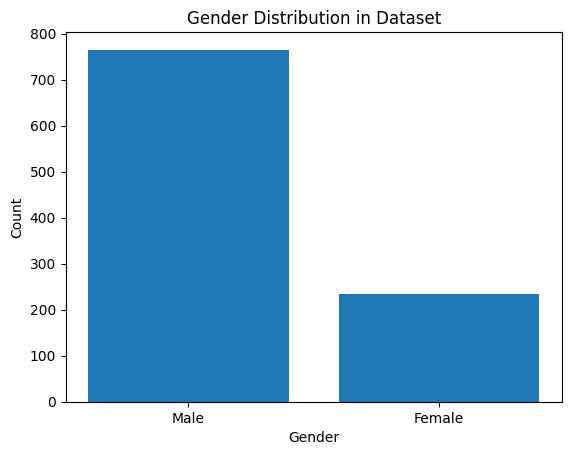

In [87]:
gender_counts = df['gender'].value_counts()
x_lab = ['Male', 'Female']
plt.bar(x_lab, gender_counts)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution in Dataset')
plt.show()

Examining each metric chest pain and how it affects rates of cardiovascular disease



In [88]:
df['chestpain'].value_counts()

0    420
2    312
1    224
3     44
Name: chestpain, dtype: int64

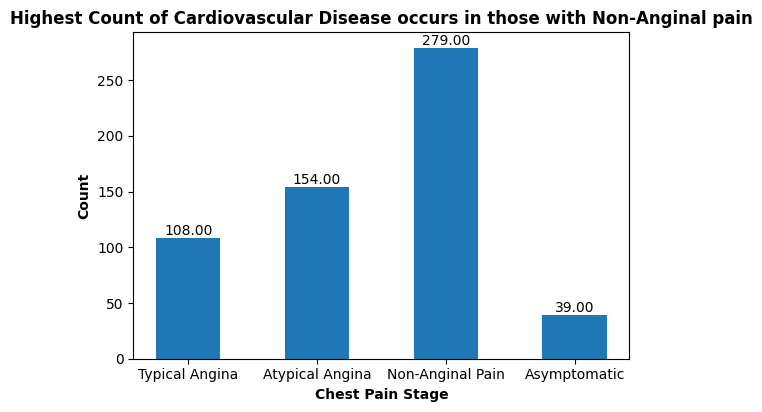

In [89]:
chestpain_count = df.groupby('chestpain').sum()['target']
bar_width = 0.5
index = range(len(chestpain_count))
plt.bar(index, chestpain_count, width=bar_width)
for i, value in enumerate(chestpain_count):
    plt.text(i, value + 0.002, f'{value:.2f}', ha='center', va='bottom')
x_labels = ['Typical Angina', 'Atypical Angina', 'Non-Anginal Pain', 'Asymptomatic']
plt.xticks(index, x_labels)
plt.xlabel('Chest Pain Stage', fontweight='bold')
plt.subplots_adjust(bottom=0.2)
plt.ylabel('Count', fontweight='bold')
plt.subplots_adjust(wspace=0.4)
plt.title('Highest Count of Cardiovascular Disease occurs in those with Non-Anginal pain', fontweight  = 'bold')
plt.show()


Now lets measure by probability of having cardiovascular disease based on the chest pain.

In [90]:
df.groupby('chestpain').mean()

,age,gender,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
chestpain,,,,,,,,,,,,
0,48.607143,0.745238,141.307143,286.280952,0.188095,0.523810,140.330952,0.521429,2.456190,1.002381,0.904762,0.257143
1,48.660714,0.745536,166.611607,318.973214,0.303571,0.772321,147.098214,0.459821,2.859821,1.642857,1.263393,0.687500
2,50.583333,0.826923,152.237179,331.644231,0.397436,1.016026,151.983974,0.500000,2.972756,2.115385,1.592949,0.894231
3,48.750000,0.613636,172.250000,370.136364,0.568182,0.863636,140.204545,0.454545,2.454545,2.068182,1.409091,0.886364


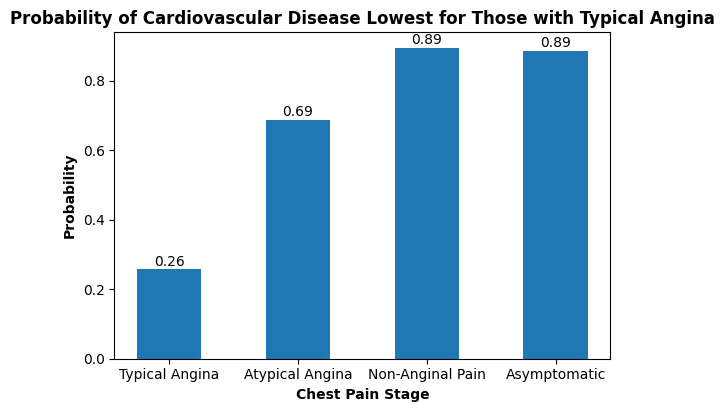

In [91]:
chestpain_mean = df.groupby('chestpain').mean()['target']
bar_width = 0.5
index = range(len(chestpain_mean))
plt.bar(index, chestpain_mean, width=bar_width)
for i, value in enumerate(chestpain_mean):
    plt.text(i, value + 0.002, f'{value:.2f}', ha='center', va='bottom')
x_labels = ['Typical Angina', 'Atypical Angina', 'Non-Anginal Pain', 'Asymptomatic']
plt.xticks(index, x_labels)
plt.xlabel('Chest Pain Stage', fontweight='bold')
plt.subplots_adjust(bottom=0.2)
plt.ylabel('Probability', fontweight='bold')
plt.subplots_adjust(wspace=0.4)
plt.title('Probability of Cardiovascular Disease Lowest for Those with Typical Angina', fontweight='bold')
plt.show()


### Lets see how the numerical features in this dataset interact with eachother through this pair plot

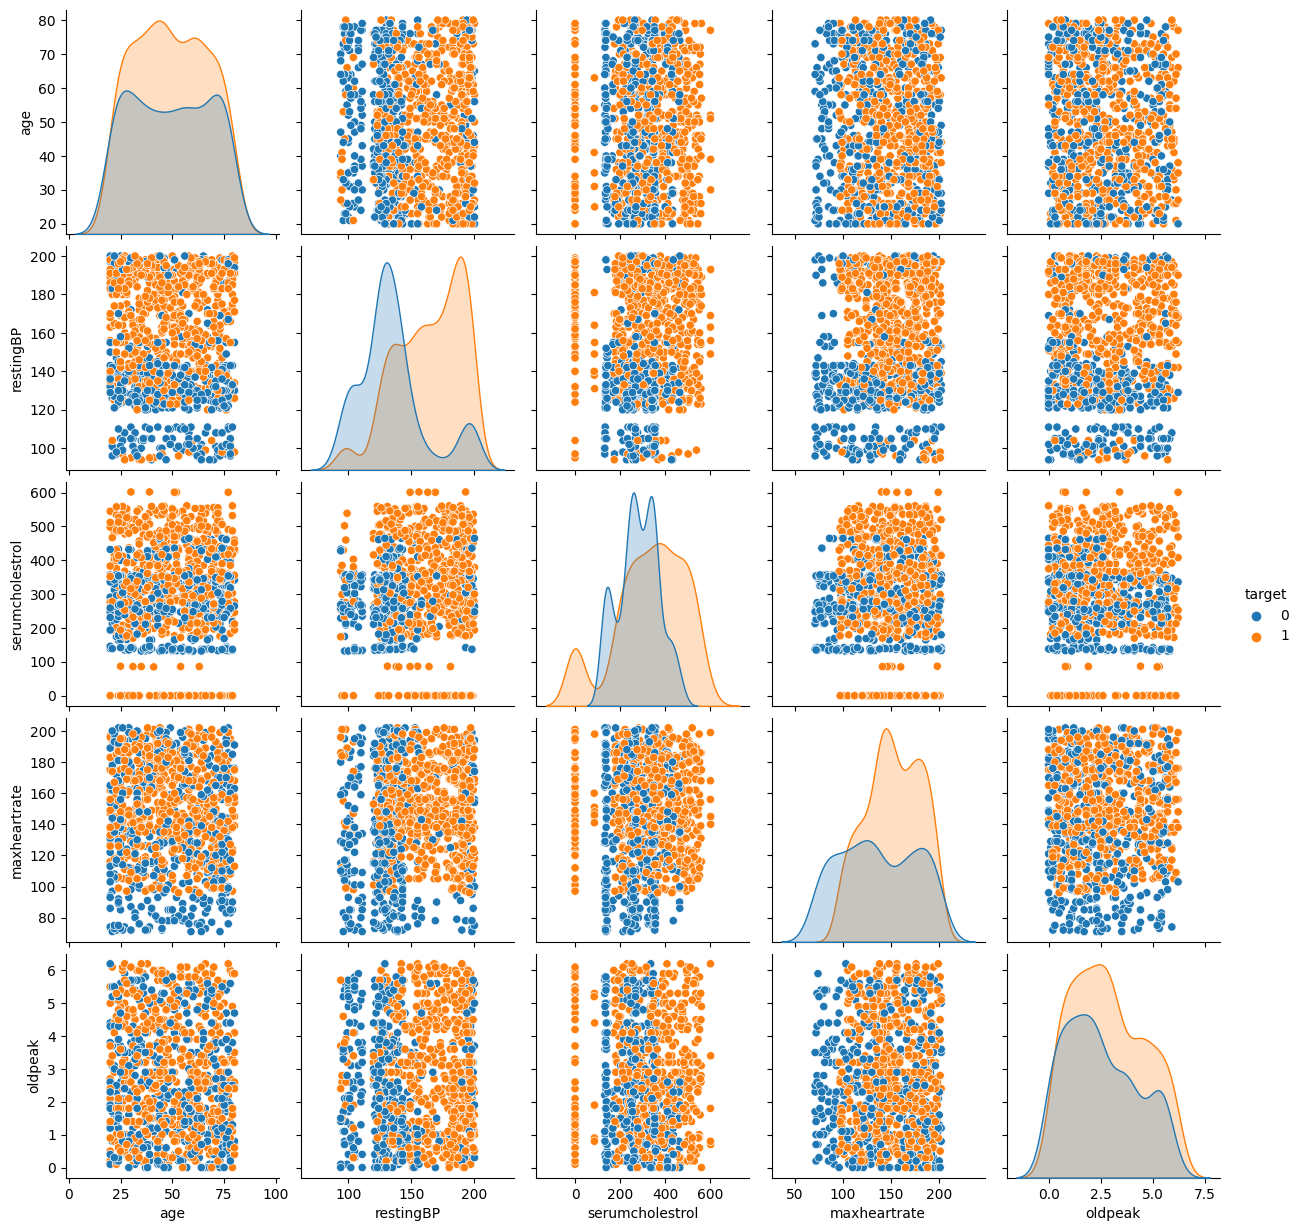

In [92]:
df_trunc_numeric = df[['age', 'restingBP',	'serumcholestrol',	'maxheartrate',	'oldpeak', 'target']]

sns.pairplot(df_trunc_numeric, hue ='target')


### EDA through boxplots

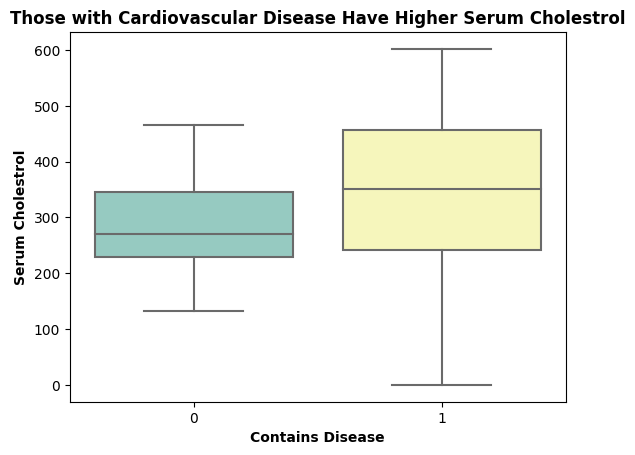

In [93]:
sns.boxplot(x='target', y='serumcholestrol', data=df, palette="Set3")
plt.xlabel('Contains Disease', fontweight='bold')
plt.ylabel('Serum Cholestrol', fontweight='bold')
plt.title('Those with Cardiovascular Disease Have Higher Serum Cholestrol', fontweight='bold')
plt.show()

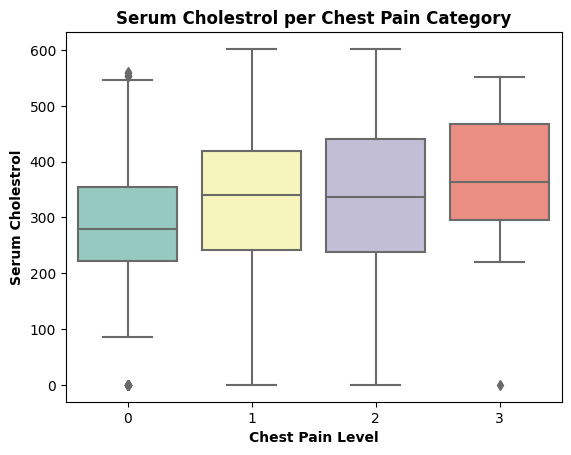

In [94]:
sns.boxplot(x='chestpain', y='serumcholestrol', data=df, palette="Set3")
plt.xlabel('Chest Pain Level', fontweight='bold')
plt.ylabel('Serum Cholestrol', fontweight='bold')
plt.title('Serum Cholestrol per Chest Pain Category', fontweight='bold')
plt.show()

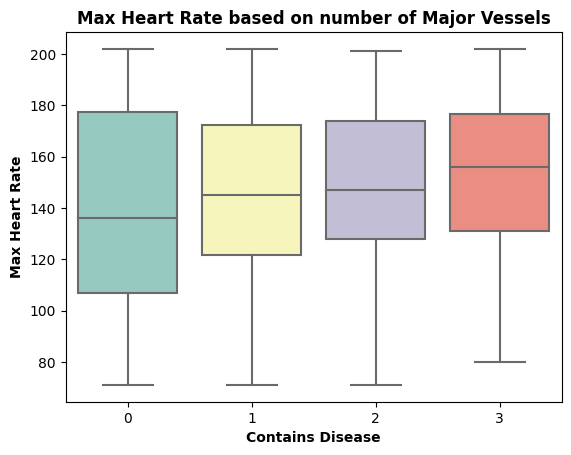

In [95]:
sns.boxplot(x='noofmajorvessels', y='maxheartrate', data=df, palette="Set3")
plt.xlabel('Contains Disease', fontweight='bold')
plt.ylabel('Max Heart Rate', fontweight='bold')
plt.title('Max Heart Rate based on number of Major Vessels', fontweight='bold')
plt.show()

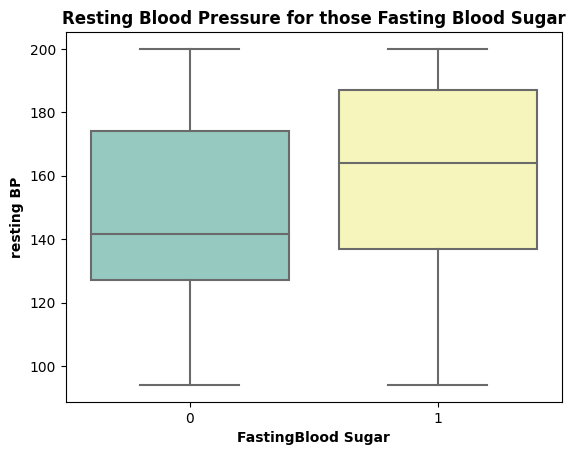

In [96]:
sns.boxplot(x='fastingbloodsugar', y='restingBP', data=df, palette="Set3")
plt.xlabel('FastingBlood Sugar', fontweight='bold')
plt.ylabel('resting BP', fontweight='bold')
plt.title('Resting Blood Pressure for those Fasting Blood Sugar', fontweight='bold')
plt.show()

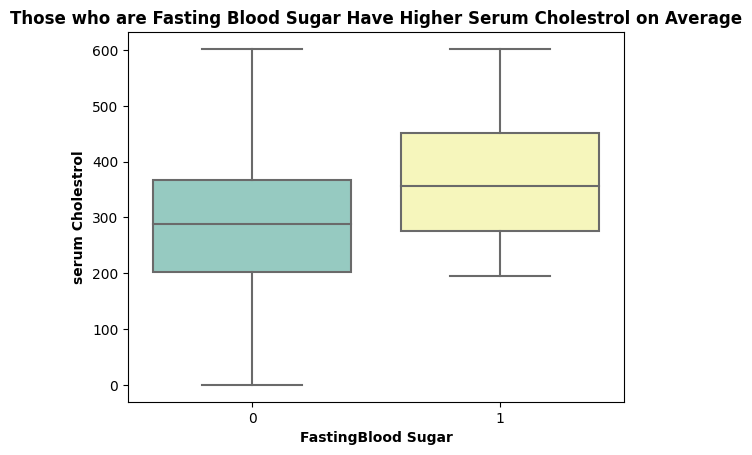

In [97]:
sns.boxplot(x='fastingbloodsugar', y='serumcholestrol', data=df, palette="Set3")
plt.xlabel('FastingBlood Sugar', fontweight='bold')
plt.ylabel('serum Cholestrol', fontweight='bold')
plt.title('Those who are Fasting Blood Sugar Have Higher Serum Cholestrol on Average', fontweight='bold')
plt.show()

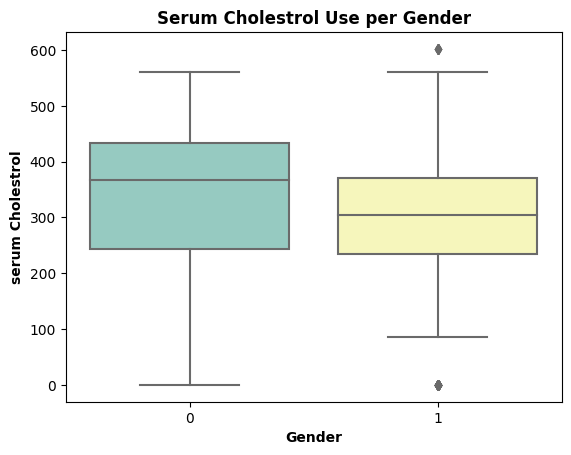

In [98]:
sns.boxplot(x='gender', y='serumcholestrol', data=df, palette="Set3")
plt.xlabel('Gender', fontweight='bold')
plt.ylabel('serum Cholestrol', fontweight='bold')
plt.title('Serum Cholestrol Use per Gender', fontweight='bold')
plt.show()

## Modeling

One Hot Encoding the categorical variables to improve accuracy for models.

In [99]:
df_encoded = pd.get_dummies(df, columns=['chestpain', 'restingrelectro', 'slope', 'noofmajorvessels'])
df_encoded = df_encoded.drop(columns = ['chestpain_0', 'restingrelectro_0', 'slope_0', 'noofmajorvessels_0'])
df_encoded.head()

,age,gender,restingBP,serumcholestrol,fastingbloodsugar,maxheartrate,exerciseangia,oldpeak,target,chestpain_1,chestpain_2,chestpain_3,restingrelectro_1,restingrelectro_2,slope_1,slope_2,slope_3,noofmajorvessels_1,noofmajorvessels_2,noofmajorvessels_3
0,53,1,171,0,0,147,0,5.3,1,0,1,0,1,0,0,0,1,0,0,1
1,40,1,94,229,0,115,0,3.7,0,0,0,0,1,0,1,0,0,1,0,0
2,49,1,133,142,0,202,1,5.0,0,0,1,0,0,0,1,0,0,0,0,0
3,43,1,138,295,1,153,0,3.2,1,0,0,0,1,0,0,1,0,0,1,0
4,31,1,199,0,0,136,0,5.3,1,1,0,0,0,1,0,0,1,0,1,0


In [100]:
from sklearn.preprocessing import StandardScaler
columns_to_standardize = ['age', 'restingBP','serumcholestrol', 'maxheartrate', 'oldpeak']
scaler = StandardScaler()
df_encoded[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
df_encoded.head()

,age,gender,restingBP,serumcholestrol,fastingbloodsugar,maxheartrate,exerciseangia,oldpeak,target,chestpain_1,chestpain_2,chestpain_3,restingrelectro_1,restingrelectro_2,slope_1,slope_2,slope_3,noofmajorvessels_1,noofmajorvessels_2,noofmajorvessels_3
0,0.210464,1,0.642833,-2.352717,0,0.044567,0,1.507245,1,0,1,0,1,0,0,0,1,0,0,1
1,-0.517591,1,-1.928098,-0.622817,0,-0.891840,0,0.576955,0,0,0,0,1,0,1,0,0,1,0,0
2,-0.013553,1,-0.625938,-1.280028,0,1.654017,1,1.332816,0,0,1,0,0,0,1,0,0,0,0,0
3,-0.349578,1,-0.458995,-0.124243,1,0.220143,0,0.286239,1,0,0,0,1,0,0,1,0,0,1,0
4,-1.021629,1,1.577717,-2.352717,0,-0.277323,0,1.507245,1,1,0,0,0,1,0,0,1,0,1,0


#### Grid Search Cross Validation

In [101]:
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

In [102]:
X = df_encoded.drop(columns = ['target'])
y=  df_encoded['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

Tuning appropriate hyperparamets per model

In [103]:
model_parameters= {
    'Logistic_Regression' : {
        'model': LogisticRegression(max_iter=1000),
        'parameters': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
            'class_weight': [None, 'balanced']
        }
    },
    'Random_Forest': {
        'model': RandomForestClassifier(),
        'parameters': {
            'max_features': [None, 'sqrt', 'log2'],
            'n_estimators': [75, 150, 250, 500, 1000],
            'criterion': ['gini', 'entropy', 'log_loss']
        }
    },
    'SVM': {
        'model': svm.SVC(),
        'parameters': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'gamma': ['scale', 'auto']
        }
    }
}

In [104]:
warnings.filterwarnings("ignore", category=UserWarning)
scores = []
for model_name, mp in model_parameters.items():
    clf = GridSearchCV(mp['model'], mp['parameters'], cv=5)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
for score in scores:
    print(score)

{'model': 'Logistic_Regression', 'best_score': 0.9640000000000001, 'best_params': {'C': 10, 'class_weight': 'balanced', 'solver': 'lbfgs'}}
{'model': 'Random_Forest', 'best_score': 0.9706666666666667, 'best_params': {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 250}}
{'model': 'SVM', 'best_score': 0.9626666666666667, 'best_params': {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}}


In [105]:
training_scores = pd.DataFrame(scores, columns = ['model', 'best_score', 'best_params'])
training_scores

,model,best_score,best_params
0,Logistic_Regression,0.964000,"{'C': 10, 'class_weight': 'balanced', 'solver'..."
1,Random_Forest,0.970667,"{'criterion': 'log_loss', 'max_features': 'sqr..."
2,SVM,0.962667,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}"


Applying Models with tuned Hyperparameters onto the Test Set

Logistic Regression On the Test Set

In [106]:
Logistic_regression_model = LogisticRegression(**scores[0]['best_params']).fit(X_train, y_train)
Logistic_regression_pred = Logistic_regression_model.predict(X_test)
print("Logistic Regression Accuracy Score:")
print(accuracy_score(y_test, Logistic_regression_pred))
conf_matrix = confusion_matrix(y_test, Logistic_regression_pred)
print("Confusion Matrix:")
print(conf_matrix)
class_report = classification_report(y_test, Logistic_regression_pred)
print("Classification Report:")
print(class_report)

Logistic Regression Accuracy Score:
0.968
Confusion Matrix:
[[108   4]
 [  4 134]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       112
           1       0.97      0.97      0.97       138

    accuracy                           0.97       250
   macro avg       0.97      0.97      0.97       250
weighted avg       0.97      0.97      0.97       250



Random Forest On the Test Set

In [107]:
random_forest_model = RandomForestClassifier(**scores[1]['best_params']).fit(X_train, y_train)
Random_forest_pred = random_forest_model.predict(X_test)
print("Random Forest Accuracy Score:")
print(accuracy_score(y_test, Random_forest_pred))
conf_matrix = confusion_matrix(y_test, Random_forest_pred)
print("Confusion Matrix:")
print(conf_matrix)
class_report = classification_report(y_test, Random_forest_pred)
print("Classification Report:")
print(class_report)

Random Forest Accuracy Score:
0.98
Confusion Matrix:
[[109   3]
 [  2 136]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       112
           1       0.98      0.99      0.98       138

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250



Support Vector Machine (SVM) On the Test Set

In [108]:
svm_model = svm.SVC(**scores[2]['best_params']).fit(X_train, y_train)
svm_model_pred = svm_model.predict(X_test)
print("SVM Accuracy Score:")
print(accuracy_score(y_test, svm_model_pred))
conf_matrix = confusion_matrix(y_test, svm_model_pred)
print("Confusion Matrix:")
print(conf_matrix)
class_report = classification_report(y_test, svm_model_pred)
print("Classification Report:")
print(class_report)

SVM Accuracy Score:
0.968
Confusion Matrix:
[[108   4]
 [  4 134]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       112
           1       0.97      0.97      0.97       138

    accuracy                           0.97       250
   macro avg       0.97      0.97      0.97       250
weighted avg       0.97      0.97      0.97       250



In [109]:
training_scores['best_params'][1]

{'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 250}

In [110]:
lr_accuracy = accuracy_score(y_test, Logistic_regression_pred)
rf_accuracy = accuracy_score(y_test, Random_forest_pred)
svm_accuracy = accuracy_score(y_test, svm_model_pred)
best_model = max([('Logistic Regression', lr_accuracy, training_scores['best_params'][0]),
                  ('Random Forest', rf_accuracy, training_scores['best_params'][1]),
                  ('SVM', svm_accuracy, training_scores['best_params'][2])],
                 key=lambda x: x[1])

print(f"\nThe most accurate model is: {best_model[0]} with accuracy: {best_model[1]} and parameters: {best_model[2]}")


The most accurate model is: Random Forest with accuracy: 0.98 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 250}


Overall, it seems that the best model is a random forest with 98% accuracy. Additionally, it has the largest F1 score, precision, and recall. Hence, for this classification problem, it is better to use a Random Forest; however, both logistic regression and SVM models were also very accurate.